In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Parareal
To solve the initial value problem
\begin{align*}
  u_t &= f(t, u), \quad t \in (0, T], \\
  u(0) &= u^0
\end{align*}
using the parareal algorithm, we require two integrators or propagators:
1. $G(t, u)$ is a coarse approximation
2. $F(t, u)$ is a more accurate, or fine, approximation

We partition the time domain into intervals (time-slices, or chunks) and use the coarse approximation $G$ to give us an initial condition for $F$ on each interval.

The more accurate (i.e. _expensive!_) approximation can now be computed in parallel for all slices at once, although obviously the later time slices do not have an accurate initial condition.

We iterate, correcting the initial condition on each interval:
  \begin{align*}
    u_0^{k+1} &= u^0 \\
    u_{n+1}^{k+1} &= F(u_n^k) + G(u_n^{k+1}) - G(u_n^k)
  \end{align*}

We will first apply parareal to the Lorenz63 chaotic system, using an RK4 method for both the coarse and the fine propagators. The coarse propagator will take a larger timestep than the fine. There are functions provided below to compute the right hand side of the Lorenz system and a single RK4 timestep.

In [2]:
def lorenz63(X, sigma=10, beta=8/3, rho=28):
    """
    Given:
       X: a point of interest in three dimensional space
       sigma, rho, beta: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x, y, z = X
    xdot = sigma * (y - x)
    ydot = x*(rho - z) - y
    zdot = x*y - beta*z
    return np.array([xdot, ydot, zdot])

In [3]:
def rk4(dt, x, f, **f_kwargs):
    """
    A single timestep for rhs function f using RK4
    """
    x1 = f(x, **f_kwargs)

    x2 = f(x+x1*dt/2.0, **f_kwargs)
    x3 = f(x+x2*dt/2.0, **f_kwargs)
    x4 = f(x+x3*dt, **f_kwargs)
    x_out = x + dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
    return x_out

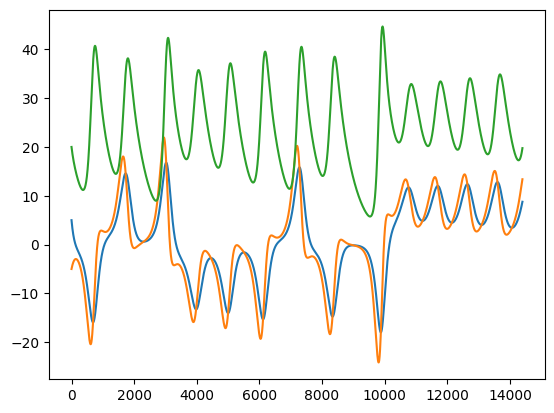

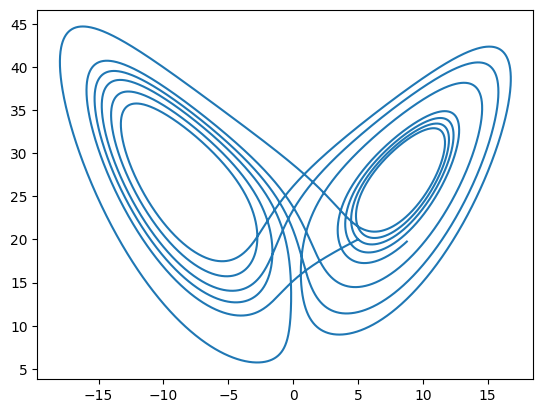

Text(0.5, 0.92, 'Lorenz Attractor')

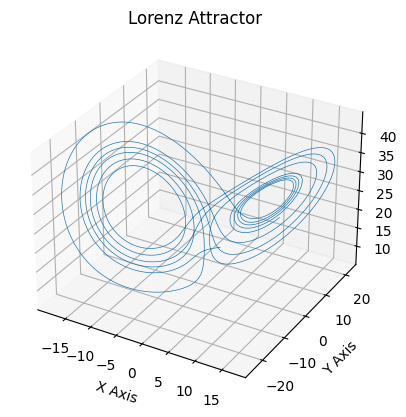

In [79]:
# initial condition
X0 = np.array((5, -5, 20))
X_soln = X0.copy()

# final time
t_max = 10

# total number of fine timesteps
total_Nf = 14400

# fine timestep
dt = t_max/total_Nf

# specify rhs function
rhs = lorenz63

X_n = X0.copy()
for nsteps in range(total_Nf):
    X_np1 = rk4(dt, X_n, rhs)
    X_soln = np.vstack((X_soln, X_np1))
    X_n = X_np1

# we can plot the time evolution of the coordinates
plt.plot(X_soln[:, 0])
plt.plot(X_soln[:, 1])
plt.plot(X_soln[:, 2])
plt.show()

# or we can plot a 2d xz plot
plt.plot(X_soln[:, 0], X_soln[:, 2])
plt.show()

ax = plt.figure().add_subplot(projection='3d')

ax.plot(*X_soln.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

We will reproduce the results from Gander and Hairer 2007. The initial condition and timesteps are given below.

In [245]:
# initial condition
X0 = np.array((5, -5, 20))

# final time
t_max = 10

# total number of coarse timesteps
Nc = 180

# coarse timestep
Dt = t_max/Nc

# total number of fine timesteps
total_Nf = 14400

# number of fine timesteps per coarse timestep
Nf = int(total_Nf/Nc)

# fine timestep
dt = t_max/total_Nf

# specify rhs function
rhs = lorenz63

# compute the first iteration using the coarse propagator
#### FILL THIS IN

initial_conditions = np.array([X0])
for step in range(1, Nc):
    G_n = rk4(Dt, initial_conditions[step - 1], rhs)
    initial_conditions = np.vstack((initial_conditions, G_n))

number_of_iterations = 20

# now write an iteration loop using the coarse propagator as an initial condition for
# the fine propagator on each time interval
for k in range(number_of_iterations):
    F_soln = np.array([X0])
    for interval in range(0, Nc):
      F_n = rk4(dt, initial_conditions[interval], rhs)
      F_soln = np.vstack((F_soln, F_n))
      for step in range(1, Nf):
        F_n = rk4(dt, F_soln[interval * Nf + step], rhs)
        F_soln = np.vstack((F_soln, F_n))

    # Corrections
    old_initial_conditions = initial_conditions.copy()
    initial_conditions = np.array([X0])
    for interval in range(1, Nc):
      G_n = rk4(Dt, F_soln[(interval - 1) * Nf], rhs)
      error = F_soln[interval * Nf + 1] - old_initial_conditions[interval]
      next_IC = error + G_n
      initial_conditions = np.vstack((initial_conditions, next_IC))
      if interval == 0:
        np.delete(initial_conditions, 0)


In [246]:
error = abs(F_soln - X_soln)
np.average(error)

5.931230413859922

Text(0.5, 0.92, 'Parareal Lorenz Attractor using 8 iterations')

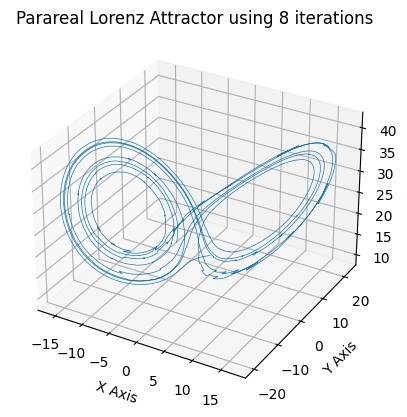

In [247]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*F_soln.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title(f"Parareal Lorenz Attractor using %d iterations" %nits)

We will now investigate the behaviour of parareal applied to the Dahlquist equation.

## Exercises
1. Apply parareal to the Dahlquist equation with $\lambda=-1$ and initial condition $x=1$. Run until $t=1$ and use 10 coarse timesteps and 20 fine timesteps per coarse timestep.
2. Now set $\lambda=2i$ so that the solution is oscillatory. Investigate the effect of changing the coarse timestep - when does the solution converge?

In [ ]:
def dahlquist(x, lamda=-1):
    return lamda*x

In [ ]:
def exact_soln(t, lamda):
    return np.exp(lamda*t)